# 1. PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment  = 'local'  # work environment ['kaggle', 'local']
    device       = 'GPU'    # training device ['GPU', 'TPU']
    device_index = 1        # device index (when using single device)
    num_devices  = 1        # no. GPU/TPU devices (modeling)
    cpu_workers  = 4        # no. CPU cores (data loading)

    # general
    version  = '15'   # notebook version (for saving outputs)
    debug    = False  # debug mode runs 10 batches for 3 epochs
    tracking = True   # track results using neptune.ai
    seed     = 13353  # random state

    # data
    num_folds = 10     # number of CV folds
    num_cuts  = 14     # number of target cuts
    features  = False  # whether to use meta features
    drop_dupl = 0.95   # whether to drop train-valid duplicates
    old_data  = 0      # percentage of old labeled data
    
    # image processing
    image_size  = 384             # image size after augmentations
    crop_scale  = (0.8, 1)        # min scale, max scale
    p_hflip     = 0.5             # prob. of horizontal flips 
    p_vflip     = 0.5             # prob. of vertical flips 
    p_transpose = 0.5             # prob. of transpose flips 
    ssr         = [0.1, 0.1, 30]  # shift, scale, rotation limits
    huesat      = [10, 10, 10]    # hue, saturation, value limits
    bricon      = [0.1, 0.1]      # brightness, contrast limits
    blur_limit  = 0               # blur limit
    dist_limit  = 0               # distortion limit
    clahe       = [0, 1]          # clip limit, size of grid
    cutout      = [0, 0.1]        # number of squares, size of squares
    p_aug       = 0.5             # prob. of augmentations except for flips
    cutmix      = [0, 1]          # cutmix batch-level probability, alpha
    normalize   = True            # pixel normalization [False, True]
    
    # architecture
    backbone    = 'swin_large_patch4_window12_384'  # backbone   
    pretrained  = 'imagenet'                        # starting weights [False, 'imagenet', path]
    target_size = 1                                 # number of neurons in output layer
    batchnorm   = False                             # whether to include batchnorm layer in head
    dropout     = 0                                 # whether to add dropout layer in head
    
    # training
    num_epochs    = 10     # no. epochs per fold
    max_batches   = False  # max no. batches per training epoch (False or int)
    batch_size    = 32     # no. images per batch 
    accum_iter    = 1      # no. batches for gradient accumulation
    use_fp16      = True   # mixed precision mode 
    grad_clip     = False  # max gradient norm (False or float)
    batch_verbose = False  # print loss every n batches
    
    # loss function
    loss_fn   = 'BCE'  # loss ['MSE', 'BCE', 'FC']
    smoothing = False  # label smoothing
    
    # LR and optimizer
    lr       = 1e-5       # starting learning rate
    lr_decay = 0          # learning rate decay in deeper layers
    optim    = 'madgrad'  # LR optimizer ['Adam', 'AdamW', 'AdamP', 'madgrad']
    decay    = 1e-4       # weight decay of optimizer (L2 regularization)

    # scheduler
    warmup        = 1         # no. epochs for warmup
    warmup_freeze = False     # whether to freeze deep layers during warmup
    scheduler     = 'cosine'  # LR scheduler after warmup
    upd_on_batch  = True      # update LR after every batch (or epoch)
    
    # inference
    predict_oof      = True  # whether to produce OOF predictions
    predict_test     = True  # whether to produce test predictions 
    valid_batch_size = 64    # no. images per batch 
    num_tta          = 1     # no. TTA flips (between 1 and 8)

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [3]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['predict_test'] = False
    CFG['tracking']     = False
    CFG['save_all']     = False
    CFG['num_epochs']   = 2
    CFG['num_folds']    = 2

# 2. PREPARATIONS

In [4]:
####### PACKAGES

if CFG['environment'] != 'local':
    !pip install timm transformers accelerate adamp madgrad
    !pip install --upgrade -U albumentations
    !pip install --upgrade neptune-client
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    
if CFG['device'] == 'TPU':
    !pip install cloud-tpu-client==0.10 'https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl'

import numpy as np
import pandas as pd
import torch

import os
import sys
import time
import pickle

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from accelerate import notebook_launcher

import warnings
import gc; gc.enable()

In [5]:
####### MODULES

# source
if CFG['environment'] == 'local':
    sys.path.append('../code')  
elif CFG['environment'] == 'kaggle':
    sys.path.append('../input/petfinder-code')  

# utilities
from utilities import *

# visualization
from sample_batch import sample_batch

# training and inference
from run_training import run_training
from run_inference import run_inference

In [6]:
####### WORKING PATHS

if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])
        
elif CFG['environment'] == 'kaggle':
    CFG['data_path']  = '../input/petfinder/'
    CFG['out_path']   = ''

In [7]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    import neptune.new as neptune
    run = neptune.init(project   = 'YOUR-PROJECT',
                       api_token = 'YOUR-TOKEN')
    run['params'] = CFG
    run['name']   = CFG['version']

https://app.neptune.ai/ml_comps/petfinder/e/PET-222
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [8]:
####### SETTINGS

warnings.filterwarnings('ignore')        # ignoring warnings
pd.options.display.max_columns = 100    # maximum displayed columns
torch.backends.cudnn.benchmark = False  # set to True if NN inputs are the same size
seed_everything(CFG['seed'])            # random seed

- setting random seed to 13353...


# 3. DATA PREP

In [9]:
####### TRAIN DATA PROCESSING

# import
df = pd.read_csv(CFG['data_path'] + 'train_10folds.csv')
df['file_path'] = df['Id'].apply(lambda x: get_train_file_path(x, CFG))

# target transformation
df['target']     = df['Pawpularity'] / 100
df['target_cat'] = pd.cut(df['target'], CFG['num_cuts'], labels = False)

# partitioning
df['fold'] = df['kfold'].astype(int)
del df['kfold']

# display
print(f'train shape: {df.shape}')
pd.crosstab(df['fold'], df['target_cat'])

train shape: (9912, 18)


target_cat,0,1,2,3,4,5,6,7,8,9,10,11,12,13
fold,,,,,,,,,,,,,,
0,33,42,111,203,188,130,84,53,41,27,19,14,11,36
1,33,42,110,203,189,130,84,53,41,27,19,14,11,36
2,33,41,110,203,189,130,84,53,41,27,20,14,10,36
3,33,41,110,203,189,130,84,53,41,27,20,14,10,36
4,33,42,110,202,188,130,84,54,41,27,20,14,10,36
5,33,42,110,203,188,129,84,54,41,27,20,14,10,36
6,33,42,110,203,188,130,84,54,40,28,20,14,10,35
7,33,42,110,203,188,130,84,53,40,28,20,14,10,36
8,33,42,110,203,188,130,84,53,40,28,20,14,10,36


In [10]:
###### TEST DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'test.csv')
sub['file_path'] = sub['Id'].apply(lambda x: get_test_file_path(x, CFG))

# subset if debug
if CFG['debug']:
    sub = sub.head(CFG['valid_batch_size'])

# display
print(f'test shape: {sub.shape}')
display(sub.head())

test shape: (8, 14)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,file_path
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1,../input/test/4128bae22183829d2b5fea10effdb0c3...
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0,../input/test/43a2262d7738e3d420d453815151079e...
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1,../input/test/4e429cead1848a298432a0acad014c9d...
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0,../input/test/80bc3ccafcc51b66303c2c263aa38486...
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0,../input/test/8f49844c382931444e68dffbe20228f4...


In [ ]:
####### OLD DATA PROCESSING

if CFG['old_data']:

    # import
    df_old = pd.read_csv(CFG['data_path'] + 'old.csv')
    df_old = df_old.loc[df_old['PhotoAmt'] > 0].reset_index(drop = True)

    # add ID
    df_old['Id']       = df_old['PetID']
    df_old['file_path'] = df_old['Id'].apply(lambda x: get_old_file_path(x, CFG))

    # target transformation
    df_old['Pawpularity'] = 25 * (4 - df_old['AdoptionSpeed'])
    df_old['target']      = df_old['Pawpularity'] / 100
    df_old['target_cat']  = pd.cut(df_old['target'], CFG['num_cuts'], labels = False)

    # remove columns
    drops = ['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
             'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
             'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
             'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed']
    df_old = df_old.drop(drops, axis = 1)

    # add columns
    adds = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
            'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
    for var in adds:
        df_old[var] = 0

    # partitioning
    df_old['fold'] = -1

    # reorder columns
    df_old = df_old.reindex(list(df.columns), axis = 1)

    # display
    print(f'train shape: {df_old.shape}')
    display(pd.crosstab(df_old['fold'], df_old['target']))
    
else:
    
    df_old = None

- setting random seed to 13353...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

- loading time: 0.3575 vs 0.1666 seconds
- inputs shape: torch.Size([5, 3, 384, 384]) vs torch.Size([5, 3, 384, 384])
- pixel values: -2.12 | 0.33 | 2.64 vs -2.12 | 0.28 | 2.64


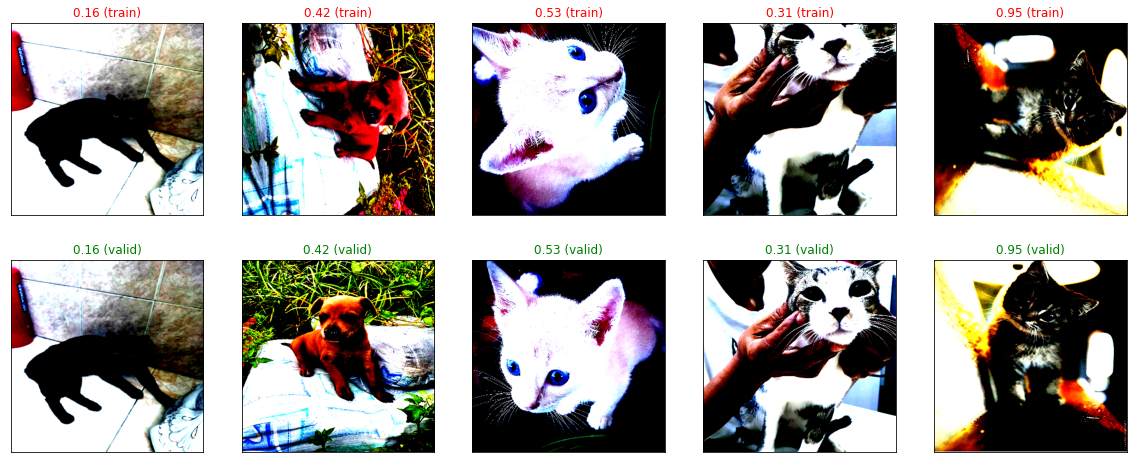

In [11]:
###### SHOW SAMPLE BATCH

_ = sample_batch(CFG         = CFG, 
                 df          = df, 
                 df_old      = df_old, 
                 sample_size = 5, 
                 batch_idx   = 8)

# 4. CROSS-VALIDATION

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
FOLD 1/10
-------------------------------------------------------
- no. images: train - 8920, valid - 992
- removing 6 duplicates from training data...
- no. images: train - 8914, valid - 992
- setting random seed to 13353...
- image size: 384, p(augment): 0.5
-------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 1/10 | lr = 0.000010 | trn_loss = 0.6564 | val_loss = 0.7470 | val_score = 18.3689 | 6.67 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 2/10 | lr = 0.000010 | trn_loss = 0.6450 | val_loss = 0.7505 | val_score = 17.9663 | 6.62 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 3/10 | lr = 0.000009 | trn_loss = 0.6410 | val_loss = 0.7482 | val_score = 17.9035 | 6.62 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 4/10 | lr = 0.000008 | trn_loss = 0.6384 | val_loss = 0.7391 | val_score = 18.1832 | 6.62 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 5/10 | lr = 0.000006 | trn_loss = 0.6346 | val_loss = 0.7455 | val_score = 17.7936 | 6.63 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 6/10 | lr = 0.000004 | trn_loss = 0.6307 | val_loss = 0.7499 | val_score = 17.9349 | 6.62 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 7/10 | lr = 0.000003 | trn_loss = 0.6261 | val_loss = 0.7409 | val_score = 17.9061 | 6.61 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 8/10 | lr = 0.000001 | trn_loss = 0.6238 | val_loss = 0.7437 | val_score = 17.9738 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 9/10 | lr = 0.000000 | trn_loss = 0.6197 | val_loss = 0.7463 | val_score = 17.9906 | 6.62 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 10/10 | lr = 0.000000 | trn_loss = 0.6175 | val_loss = 0.7437 | val_score = 18.0624 | 6.63 min
-------------------------------------------------------
Best: score = 17.7936 (epoch 5)
-------------------------------------------------------


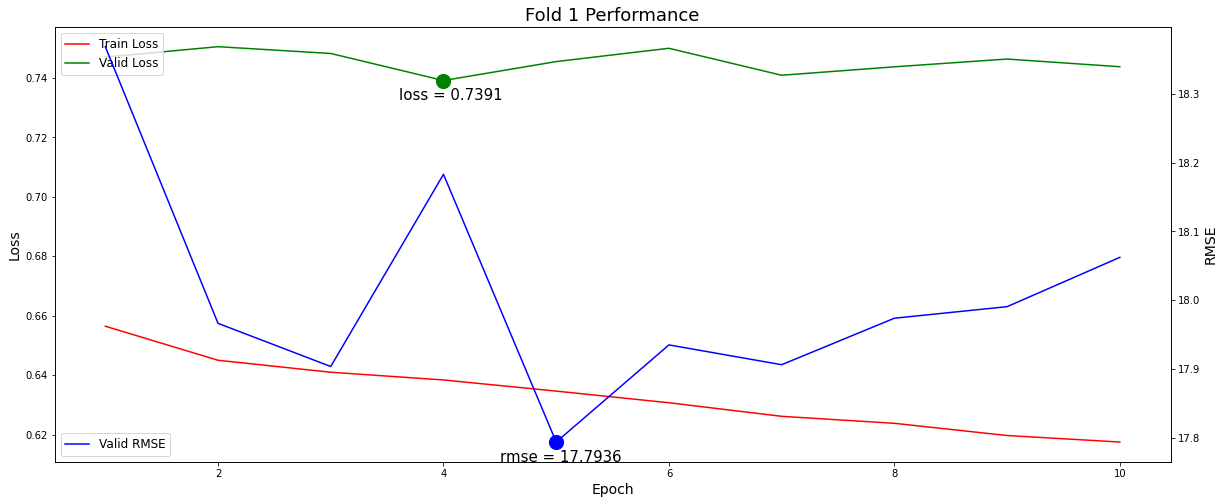

-------------------------------------------------------
FOLD 2/10
-------------------------------------------------------
- no. images: train - 8920, valid - 992
- removing 5 duplicates from training data...
- no. images: train - 8915, valid - 992
- setting random seed to 13354...
- image size: 384, p(augment): 0.5
-------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 1/10 | lr = 0.000010 | trn_loss = 0.6550 | val_loss = 0.7473 | val_score = 18.4149 | 6.62 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 2/10 | lr = 0.000010 | trn_loss = 0.6462 | val_loss = 0.7548 | val_score = 18.6491 | 6.63 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 3/10 | lr = 0.000009 | trn_loss = 0.6439 | val_loss = 0.7470 | val_score = 18.2899 | 6.62 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 4/10 | lr = 0.000008 | trn_loss = 0.6399 | val_loss = 0.7475 | val_score = 17.9808 | 6.63 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 5/10 | lr = 0.000006 | trn_loss = 0.6371 | val_loss = 0.7465 | val_score = 17.8282 | 6.65 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 6/10 | lr = 0.000004 | trn_loss = 0.6333 | val_loss = 0.7429 | val_score = 17.9112 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 7/10 | lr = 0.000003 | trn_loss = 0.6290 | val_loss = 0.7391 | val_score = 18.0719 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 8/10 | lr = 0.000001 | trn_loss = 0.6254 | val_loss = 0.7380 | val_score = 18.1319 | 6.67 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 9/10 | lr = 0.000000 | trn_loss = 0.6225 | val_loss = 0.7453 | val_score = 17.9576 | 6.66 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 10/10 | lr = 0.000000 | trn_loss = 0.6202 | val_loss = 0.7411 | val_score = 18.0629 | 6.65 min
-------------------------------------------------------
Best: score = 17.8282 (epoch 5)
-------------------------------------------------------


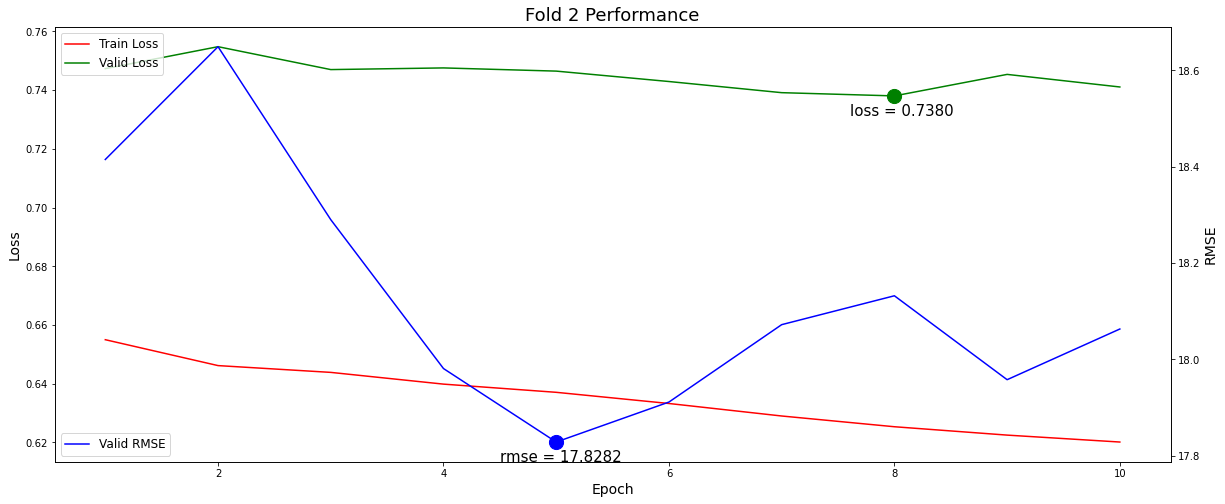

-------------------------------------------------------
FOLD 3/10
-------------------------------------------------------
- no. images: train - 8921, valid - 991
- removing 4 duplicates from training data...
- no. images: train - 8917, valid - 991
- setting random seed to 13355...
- image size: 384, p(augment): 0.5
-------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 1/10 | lr = 0.000010 | trn_loss = 0.6574 | val_loss = 0.7479 | val_score = 18.0942 | 6.65 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 2/10 | lr = 0.000010 | trn_loss = 0.6452 | val_loss = 0.7472 | val_score = 17.8246 | 6.64 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 3/10 | lr = 0.000009 | trn_loss = 0.6397 | val_loss = 0.7502 | val_score = 17.5320 | 6.64 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 4/10 | lr = 0.000008 | trn_loss = 0.6379 | val_loss = 0.7491 | val_score = 17.6637 | 6.66 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 5/10 | lr = 0.000006 | trn_loss = 0.6333 | val_loss = 0.7471 | val_score = 17.4650 | 6.65 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 6/10 | lr = 0.000004 | trn_loss = 0.6304 | val_loss = 0.7432 | val_score = 17.6207 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 7/10 | lr = 0.000003 | trn_loss = 0.6267 | val_loss = 0.7426 | val_score = 17.8455 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 8/10 | lr = 0.000001 | trn_loss = 0.6236 | val_loss = 0.7452 | val_score = 17.6877 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 9/10 | lr = 0.000000 | trn_loss = 0.6196 | val_loss = 0.7410 | val_score = 17.9403 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 10/10 | lr = 0.000000 | trn_loss = 0.6170 | val_loss = 0.7393 | val_score = 18.1007 | 6.65 min
-------------------------------------------------------
Best: score = 17.4650 (epoch 5)
-------------------------------------------------------


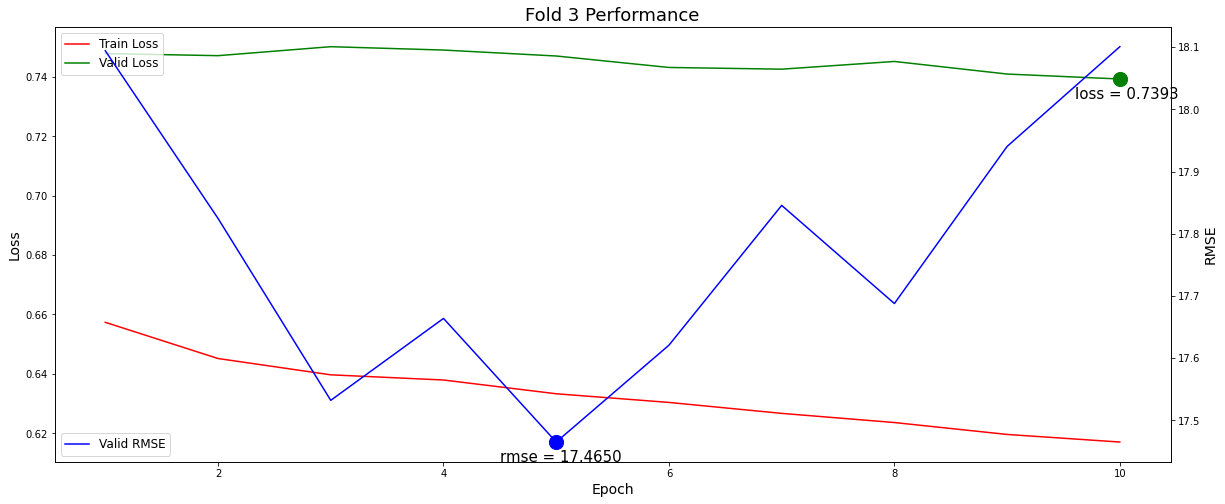

-------------------------------------------------------
FOLD 4/10
-------------------------------------------------------
- no. images: train - 8921, valid - 991
- removing 7 duplicates from training data...
- no. images: train - 8914, valid - 991
- setting random seed to 13356...
- image size: 384, p(augment): 0.5
-------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 1/10 | lr = 0.000010 | trn_loss = 0.6563 | val_loss = 0.7525 | val_score = 18.4587 | 6.65 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 2/10 | lr = 0.000010 | trn_loss = 0.6441 | val_loss = 0.7409 | val_score = 18.5690 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 3/10 | lr = 0.000009 | trn_loss = 0.6396 | val_loss = 0.7453 | val_score = 18.2422 | 6.64 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 4/10 | lr = 0.000008 | trn_loss = 0.6357 | val_loss = 0.7396 | val_score = 18.5966 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 5/10 | lr = 0.000006 | trn_loss = 0.6326 | val_loss = 0.7430 | val_score = 18.5085 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 6/10 | lr = 0.000004 | trn_loss = 0.6305 | val_loss = 0.7494 | val_score = 18.6901 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 7/10 | lr = 0.000003 | trn_loss = 0.6250 | val_loss = 0.7473 | val_score = 18.9075 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 8/10 | lr = 0.000001 | trn_loss = 0.6215 | val_loss = 0.7419 | val_score = 18.8134 | 6.63 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 9/10 | lr = 0.000000 | trn_loss = 0.6178 | val_loss = 0.7416 | val_score = 18.8827 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 10/10 | lr = 0.000000 | trn_loss = 0.6161 | val_loss = 0.7437 | val_score = 18.9701 | 6.64 min
-------------------------------------------------------
Best: score = 18.2422 (epoch 3)
-------------------------------------------------------


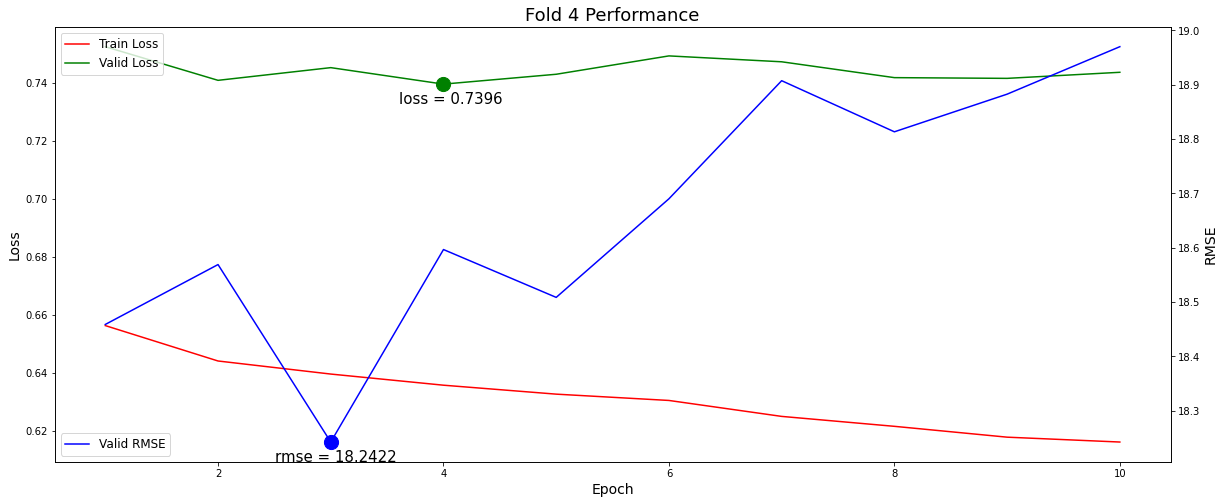

-------------------------------------------------------
FOLD 5/10
-------------------------------------------------------
- no. images: train - 8921, valid - 991
- removing 7 duplicates from training data...
- no. images: train - 8914, valid - 991
- setting random seed to 13357...
- image size: 384, p(augment): 0.5
-------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 1/10 | lr = 0.000010 | trn_loss = 0.6566 | val_loss = 0.7373 | val_score = 19.1075 | 6.64 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 2/10 | lr = 0.000010 | trn_loss = 0.6450 | val_loss = 0.7455 | val_score = 17.9838 | 6.64 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 3/10 | lr = 0.000009 | trn_loss = 0.6405 | val_loss = 0.7492 | val_score = 18.1456 | 6.63 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 4/10 | lr = 0.000008 | trn_loss = 0.6361 | val_loss = 0.7386 | val_score = 18.4206 | 6.63 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 5/10 | lr = 0.000006 | trn_loss = 0.6332 | val_loss = 0.7455 | val_score = 18.0877 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 6/10 | lr = 0.000004 | trn_loss = 0.6296 | val_loss = 0.7447 | val_score = 17.9780 | 6.63 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 7/10 | lr = 0.000003 | trn_loss = 0.6255 | val_loss = 0.7397 | val_score = 18.3618 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 8/10 | lr = 0.000001 | trn_loss = 0.6212 | val_loss = 0.7461 | val_score = 18.3432 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 9/10 | lr = 0.000000 | trn_loss = 0.6188 | val_loss = 0.7472 | val_score = 18.5484 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 10/10 | lr = 0.000000 | trn_loss = 0.6169 | val_loss = 0.7407 | val_score = 18.6766 | 6.65 min
-------------------------------------------------------
Best: score = 17.9780 (epoch 6)
-------------------------------------------------------


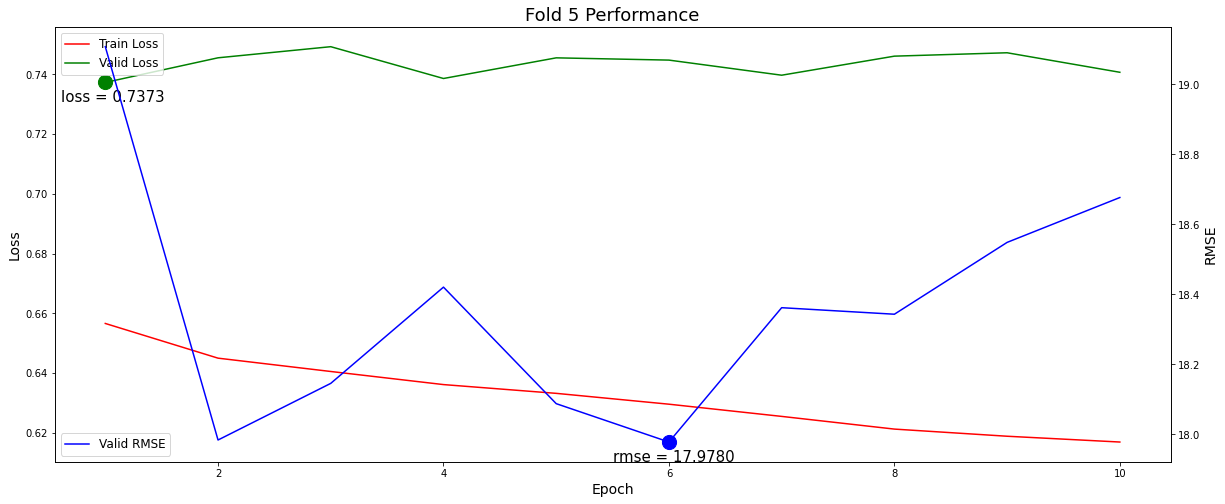

-------------------------------------------------------
FOLD 6/10
-------------------------------------------------------
- no. images: train - 8921, valid - 991
- removing 8 duplicates from training data...
- no. images: train - 8913, valid - 991
- setting random seed to 13358...
- image size: 384, p(augment): 0.5
-------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 1/10 | lr = 0.000010 | trn_loss = 0.6552 | val_loss = 0.7455 | val_score = 17.7767 | 6.64 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 2/10 | lr = 0.000010 | trn_loss = 0.6454 | val_loss = 0.7406 | val_score = 17.7328 | 6.64 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 3/10 | lr = 0.000009 | trn_loss = 0.6412 | val_loss = 0.7475 | val_score = 17.2884 | 6.64 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 4/10 | lr = 0.000008 | trn_loss = 0.6374 | val_loss = 0.7480 | val_score = 17.2516 | 6.65 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 5/10 | lr = 0.000006 | trn_loss = 0.6336 | val_loss = 0.7468 | val_score = 17.1447 | 6.65 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 6/10 | lr = 0.000004 | trn_loss = 0.6303 | val_loss = 0.7432 | val_score = 17.1819 | 6.63 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 7/10 | lr = 0.000003 | trn_loss = 0.6261 | val_loss = 0.7464 | val_score = 17.2364 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 8/10 | lr = 0.000001 | trn_loss = 0.6233 | val_loss = 0.7451 | val_score = 17.3624 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 9/10 | lr = 0.000000 | trn_loss = 0.6197 | val_loss = 0.7426 | val_score = 17.2812 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 10/10 | lr = 0.000000 | trn_loss = 0.6172 | val_loss = 0.7393 | val_score = 17.4796 | 6.66 min
-------------------------------------------------------
Best: score = 17.1447 (epoch 5)
-------------------------------------------------------


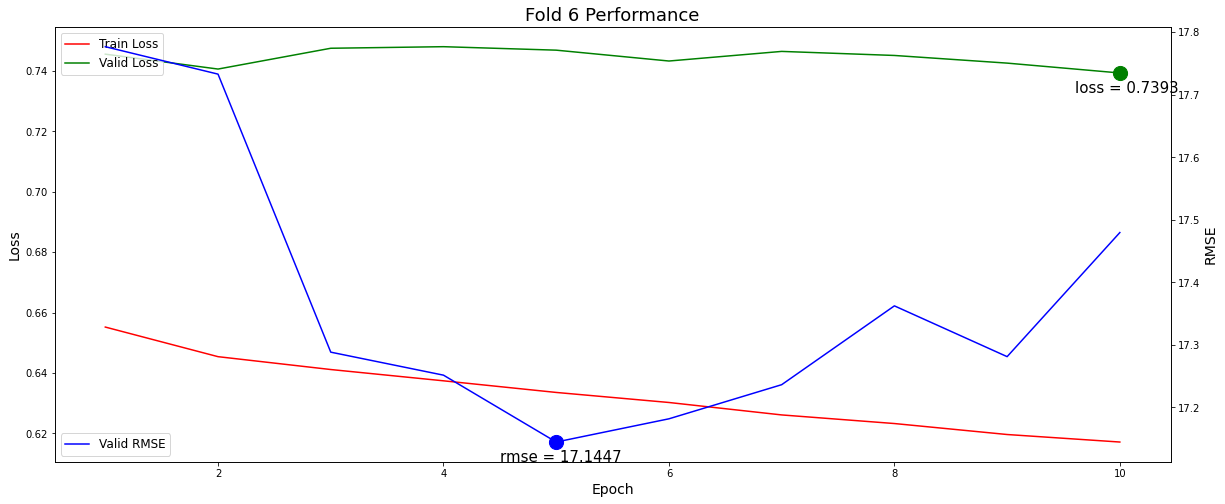

-------------------------------------------------------
FOLD 7/10
-------------------------------------------------------
- no. images: train - 8921, valid - 991
- removing 7 duplicates from training data...
- no. images: train - 8914, valid - 991
- setting random seed to 13359...
- image size: 384, p(augment): 0.5
-------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 1/10 | lr = 0.000010 | trn_loss = 0.6551 | val_loss = 0.7510 | val_score = 17.9667 | 6.64 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 2/10 | lr = 0.000010 | trn_loss = 0.6455 | val_loss = 0.7497 | val_score = 17.5510 | 6.65 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 3/10 | lr = 0.000009 | trn_loss = 0.6417 | val_loss = 0.7424 | val_score = 17.5887 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 4/10 | lr = 0.000008 | trn_loss = 0.6405 | val_loss = 0.7511 | val_score = 17.5868 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 5/10 | lr = 0.000006 | trn_loss = 0.6357 | val_loss = 0.7418 | val_score = 17.6070 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 6/10 | lr = 0.000004 | trn_loss = 0.6317 | val_loss = 0.7384 | val_score = 17.8325 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 7/10 | lr = 0.000003 | trn_loss = 0.6274 | val_loss = 0.7392 | val_score = 17.7023 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 8/10 | lr = 0.000001 | trn_loss = 0.6244 | val_loss = 0.7425 | val_score = 17.7219 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 9/10 | lr = 0.000000 | trn_loss = 0.6209 | val_loss = 0.7431 | val_score = 17.7569 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 10/10 | lr = 0.000000 | trn_loss = 0.6186 | val_loss = 0.7421 | val_score = 17.9487 | 6.66 min
-------------------------------------------------------
Best: score = 17.5510 (epoch 2)
-------------------------------------------------------


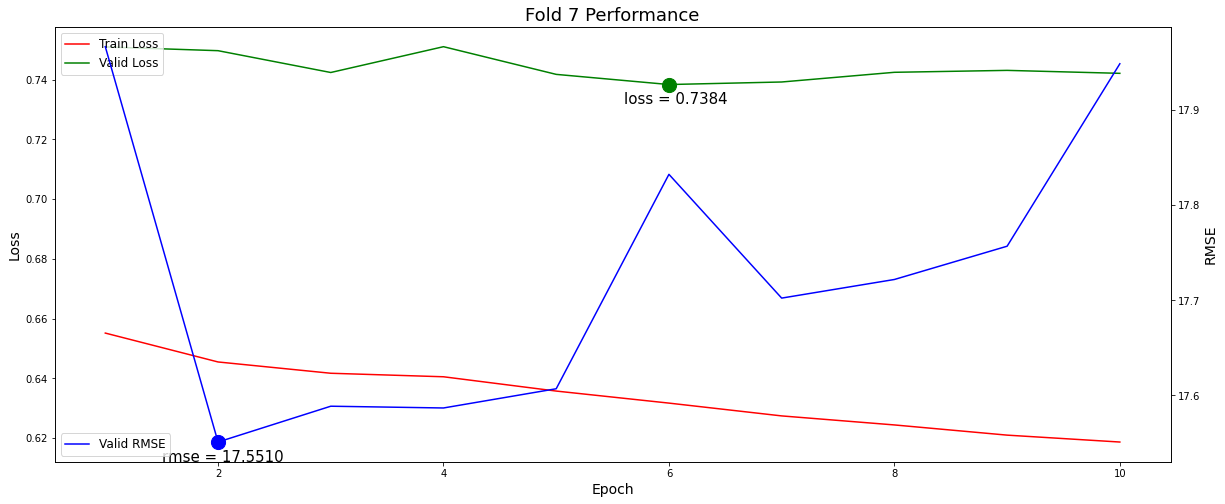

-------------------------------------------------------
FOLD 8/10
-------------------------------------------------------
- no. images: train - 8921, valid - 991
- removing 4 duplicates from training data...
- no. images: train - 8917, valid - 991
- setting random seed to 13360...
- image size: 384, p(augment): 0.5
-------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 1/10 | lr = 0.000010 | trn_loss = 0.6565 | val_loss = 0.7476 | val_score = 17.8064 | 6.65 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 2/10 | lr = 0.000010 | trn_loss = 0.6456 | val_loss = 0.7493 | val_score = 17.4281 | 6.65 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 3/10 | lr = 0.000009 | trn_loss = 0.6407 | val_loss = 0.7455 | val_score = 17.3078 | 6.63 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 4/10 | lr = 0.000008 | trn_loss = 0.6378 | val_loss = 0.7459 | val_score = 17.4652 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 5/10 | lr = 0.000006 | trn_loss = 0.6338 | val_loss = 0.7490 | val_score = 17.5969 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 6/10 | lr = 0.000004 | trn_loss = 0.6293 | val_loss = 0.7428 | val_score = 17.4326 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 7/10 | lr = 0.000003 | trn_loss = 0.6266 | val_loss = 0.7485 | val_score = 17.8659 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 8/10 | lr = 0.000001 | trn_loss = 0.6224 | val_loss = 0.7410 | val_score = 17.7188 | 6.65 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 9/10 | lr = 0.000000 | trn_loss = 0.6184 | val_loss = 0.7453 | val_score = 17.8318 | 6.66 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 10/10 | lr = 0.000000 | trn_loss = 0.6168 | val_loss = 0.7428 | val_score = 17.9831 | 6.65 min
-------------------------------------------------------
Best: score = 17.3078 (epoch 3)
-------------------------------------------------------


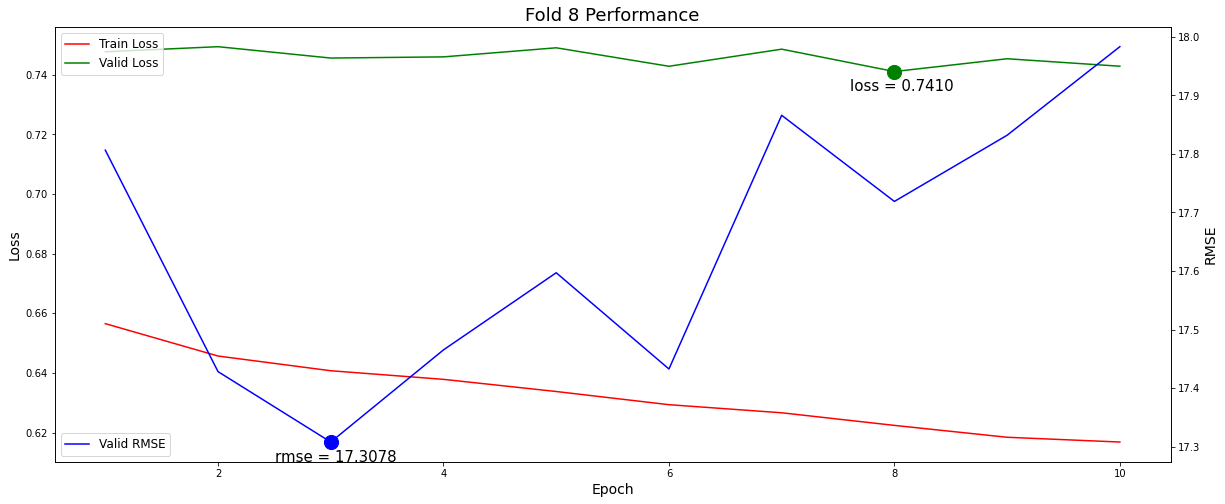

-------------------------------------------------------
FOLD 9/10
-------------------------------------------------------
- no. images: train - 8921, valid - 991
- removing 3 duplicates from training data...
- no. images: train - 8918, valid - 991
- setting random seed to 13361...
- image size: 384, p(augment): 0.5
-------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 1/10 | lr = 0.000010 | trn_loss = 0.6539 | val_loss = 0.7470 | val_score = 18.0674 | 6.64 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 2/10 | lr = 0.000010 | trn_loss = 0.6454 | val_loss = 0.7478 | val_score = 17.7605 | 6.63 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 3/10 | lr = 0.000009 | trn_loss = 0.6418 | val_loss = 0.7497 | val_score = 17.5247 | 6.63 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 4/10 | lr = 0.000008 | trn_loss = 0.6371 | val_loss = 0.7392 | val_score = 17.7709 | 6.63 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 5/10 | lr = 0.000006 | trn_loss = 0.6352 | val_loss = 0.7404 | val_score = 17.5712 | 6.63 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 6/10 | lr = 0.000004 | trn_loss = 0.6319 | val_loss = 0.7433 | val_score = 17.7588 | 6.63 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 7/10 | lr = 0.000003 | trn_loss = 0.6281 | val_loss = 0.7450 | val_score = 17.5886 | 6.63 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 8/10 | lr = 0.000001 | trn_loss = 0.6251 | val_loss = 0.7386 | val_score = 18.0489 | 6.63 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 9/10 | lr = 0.000000 | trn_loss = 0.6220 | val_loss = 0.7426 | val_score = 17.7784 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 10/10 | lr = 0.000000 | trn_loss = 0.6201 | val_loss = 0.7396 | val_score = 17.9404 | 6.63 min
-------------------------------------------------------
Best: score = 17.5247 (epoch 3)
-------------------------------------------------------


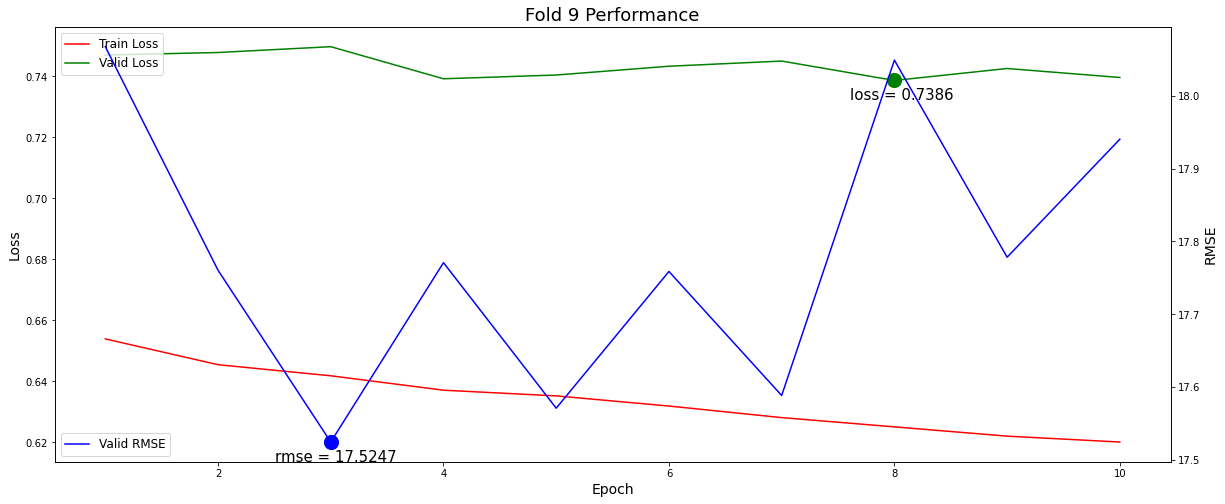

-------------------------------------------------------
FOLD 10/10
-------------------------------------------------------
- no. images: train - 8921, valid - 991
- removing 11 duplicates from training data...
- no. images: train - 8910, valid - 991
- setting random seed to 13362...
- image size: 384, p(augment): 0.5
-------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 1/10 | lr = 0.000010 | trn_loss = 0.6543 | val_loss = 0.7417 | val_score = 18.5935 | 6.62 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 2/10 | lr = 0.000010 | trn_loss = 0.6448 | val_loss = 0.7454 | val_score = 17.8543 | 6.62 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 3/10 | lr = 0.000009 | trn_loss = 0.6406 | val_loss = 0.7432 | val_score = 17.6880 | 6.62 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 4/10 | lr = 0.000008 | trn_loss = 0.6371 | val_loss = 0.7471 | val_score = 17.6957 | 6.61 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 5/10 | lr = 0.000006 | trn_loss = 0.6339 | val_loss = 0.7443 | val_score = 17.5944 | 6.62 min
-- saving model weights...


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 6/10 | lr = 0.000004 | trn_loss = 0.6298 | val_loss = 0.7380 | val_score = 17.8292 | 6.62 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 7/10 | lr = 0.000003 | trn_loss = 0.6264 | val_loss = 0.7427 | val_score = 17.7031 | 6.62 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 8/10 | lr = 0.000001 | trn_loss = 0.6222 | val_loss = 0.7440 | val_score = 17.7928 | 6.64 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 9/10 | lr = 0.000000 | trn_loss = 0.6191 | val_loss = 0.7422 | val_score = 17.8277 | 6.63 min


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

-- epoch 10/10 | lr = 0.000000 | trn_loss = 0.6174 | val_loss = 0.7420 | val_score = 17.8713 | 6.62 min
-------------------------------------------------------
Best: score = 17.5944 (epoch 5)
-------------------------------------------------------


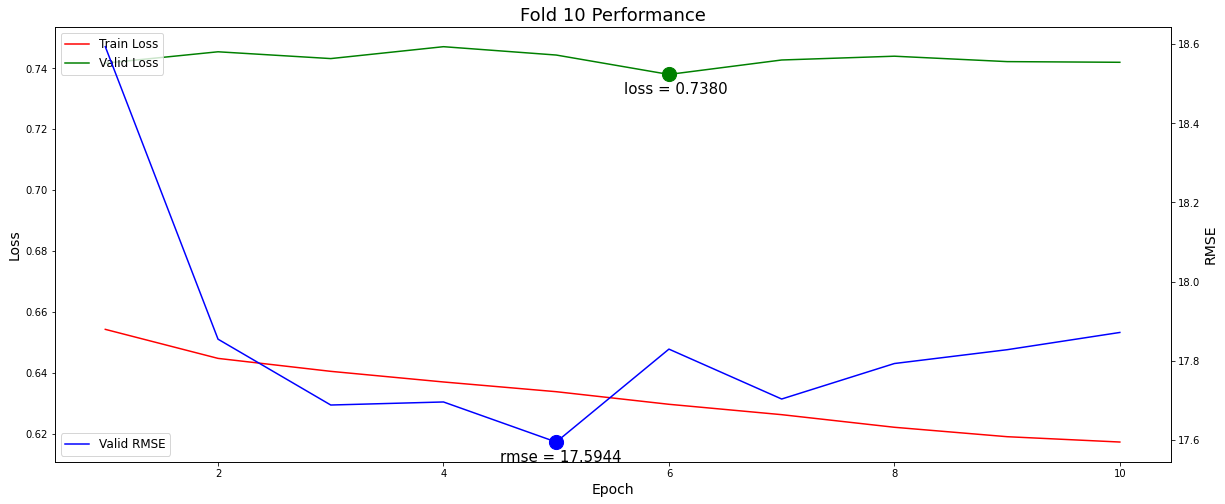


-------------------------------------------------------
Mean OOF score = 17.6430
-------------------------------------------------------

Finished in 665.39 minutes


In [12]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_training,
                  args          = (CFG, df, df_old, run) if CFG['tracking'] else (CFG, df, df_old),
                  num_processes = CFG['num_devices'],
                  use_fp16      = CFG['use_fp16'])

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

# 5. INFERENCE

In [13]:
####### INFERENCE LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_inference,
                  args          = (df, df_old, sub, CFG, run) if CFG['tracking'] else (df, df_old, sub, CFG),
                  num_processes = 1,
                  use_fp16      = CFG['use_fp16'])

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
FOLD 1/10
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
FOLD 2/10
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
FOLD 3/10
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
FOLD 4/10
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
FOLD 5/10
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
FOLD 6/10
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
FOLD 7/10
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
FOLD 8/10
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
FOLD 9/10
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
FOLD 10/10
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Finished in 3.72 minutes


In [14]:
####### CHECK OOF PERFORMANCE

# import OOF
oof = pd.read_csv(CFG['out_path'] + 'oof.csv')

# compute score
CFG['oof_score_tta'] = get_score(oof['target'], oof['pred'])

# print performance
print('-' * 30)
print('OOF with TTA = {:.4f}'.format(CFG['oof_score_tta']))
print('-' * 30)

------------------------------
OOF with TTA = 17.6463
------------------------------


In [15]:
####### EXPORT CONFIGURATION

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

# send data to Neptune
if CFG['tracking']:
    run['oof_score_tta'] = CFG['oof_score_tta']
    run['configuration'].upload(CFG['out_path'] + 'configuration.pkl')
    run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 15 operations to synchronize with Neptune. Do not kill this process.


All 15 operations synced, thanks for waiting!


# 6. ERROR ANALYSIS

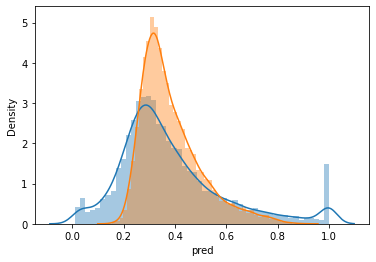

In [16]:
# import OOF
oof = pd.read_csv(CFG['out_path'] + 'oof.csv')

# plot density
import seaborn as sns
sns.distplot(oof['target']);
sns.distplot(oof['pred']);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

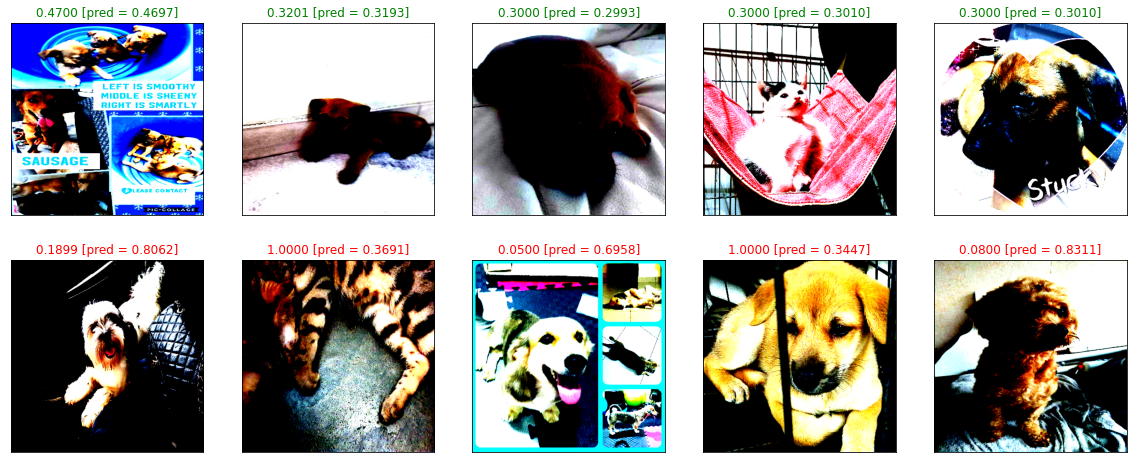

In [17]:
# show images with errors 
from plot_predictions import plot_predictions
_ = plot_predictions(CFG = CFG, fold = 0, sample_size = 5)